In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy.optimize as SciOpt
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.model.builder import LearnedCostModelBuilder, ClassicModel, FlexibleModel
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost
import endure.lsm.cost_model as CostFunc

In [4]:
model_path = '/data/models/lcm/qcost-10-03/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [5]:
config['job']['LCMTrain']

{'max_epochs': 100,
 'save_dir': 'models/lcm/qcost-10-03',
 'use_gpu_if_avail': True,
 'loss_fn': 'Huber',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'no_checkpoint': False,
 'train': {'dir': 'train-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 4096,
  'shuffle': True,
  'num_workers': 12,
  'drop_last': True},
 'test': {'dir': 'test-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 65536,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [6]:
lsm_design

'QLSM'

In [7]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars']:
    gen = Gen.QCostGenerator(config)
else:
    gen = Gen.ClassicGenerator(config)
cf = EndureCost(config)

# Loss Graph

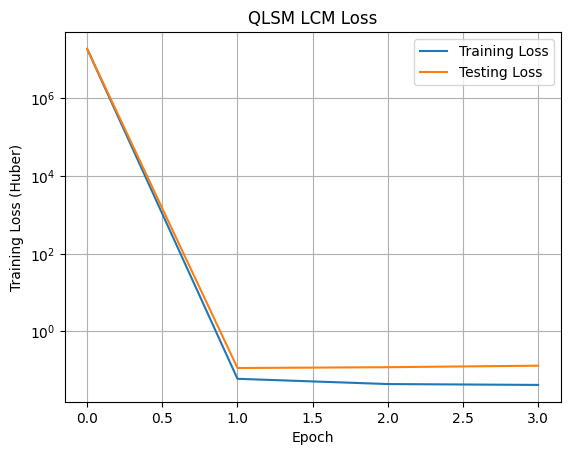

In [8]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:100]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'{lsm_design} LCM Loss')
_ = ax.legend()

In [9]:
losses.idxmin()

epoch         0
train_loss    3
test_loss     1
dtype: int64

# Building

## Model

In [10]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_02.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [11]:
model

QModel(
  (embedding): Sequential(
    (0): Linear(in_features=30, out_features=8, bias=True)
  )
  (q_embedding): Sequential(
    (0): Linear(in_features=30, out_features=8, bias=True)
  )
  (cost_layer): Sequential(
    (0): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=26, out_features=128, bias=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=128, out_features=128, bias=True)
    (14): Dropout(p=0.1, inplace=False)
    (15): LeakyReLU(nega

# Utils

In [12]:
def to_array(workload: dict):
    return np.array([workload[x] for x in ('z0', 'z1', 'q', 'w')])

In [13]:
def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

In [14]:
def create_classic_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    T = np.eye(categories, dtype=np.int32)[T]
    policy = np.eye(2, dtype=np.int32)[design.policy.value]
    feats = np.array([z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h])
    inputs = np.concatenate((feats, policy, T))
    
    return inputs

In [15]:
def create_qlsm_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    one_hot_matrix = np.eye(categories, dtype=np.int32)
    T = design.T - config['lsm']['size_ratio']['min']
    T = one_hot_matrix[T]
    Q = design.Q - 1
    Q = one_hot_matrix[Q]
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), T, Q))
    
    return inputs

In [16]:
def create_qlsm_int_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    Q = design.Q - 1
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), np.array([T, Q])))
    
    return inputs

In [17]:
def create_klsm_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    one_hot_matrix = np.eye(categories, dtype=np.int32)
    T = design.T - config['lsm']['size_ratio']['min']
    T = one_hot_matrix[T]
    capacities = (0 if cap == 0 else cap - 1  for cap in design.K)
    one_hot_cap = (one_hot_matrix[cap] for cap in capacities)
    k = np.array(list(one_hot_cap)).flatten()
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), T, k))
    
    return inputs

In [18]:
def eval_lcm(design, system, z0, z1, q, w):
    if design.policy == Policy.KHybrid:
        inputs = create_klsm_input(design, system)
    elif lsm_design == "QLSMIntegerVars":
        inputs = create_qlsm_int_input(design, system)
    elif design.policy in (Policy.Tiering, Policy.Leveling):
        inputs = create_classic_input(design, system)
    elif design.policy == Policy.QFixed:
        inputs = create_qlsm_input(design, system)
    
    inputs = torch.from_numpy(inputs).to(torch.float).view(1, -1)
    model.eval()
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item()
    return pred

In [20]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
cf.calc_cost(design, system, z0, z1, q, w), eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=2.686, T=13, policy=<Policy.QFixed: 3>, Q=7, Y=1.0, Z=1.0, K=[])
System(E=4096, s=7.13685487237328e-08, B=32.0, N=980081488, H=19.958368434178972, phi=1.0)


(14.421029538860212, 12.089845657348633)

In [21]:
(system.N * system.s) / system.B

2.1858435446736424

In [22]:
(cf.Z0(design, system)), (cf.Z1(design, system)), (cf.Q(design, system)), (cf.W(design, system))

(2.58247068715451, 2.1329808947547497, 17.121835567411097, 0.18098459721429314)

## Learned-Cost-Model Estimation To Analytical

### Single Variable Estimation

In [23]:
# def generate_single_var_estimation(wl, system=None):
#     if system is None:
#         system = System()
#     (z0, z1, q, w) = wl
#     table = []
#     design = LSMDesign(h=2, T=10, policy=Policy.Tiering)
#     # for val in tqdm(np.arange(2, 50, 1)):
#     #     design.T = val
#     for val in tqdm(np.arange(0, 9, 0.1)):
#         design.h = val
#         cost_lcm = eval_lcm(design, system, z0, z1, q, w)
#         cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
#         row = {
#             "z0": z0,
#             "z1": z1,
#             "q": q,
#             "w": w,
#             "B": system.B,
#             "s": system.s,
#             "E": system.E,
#             "H": system.H,
#             "N": system.N,
#             'h': design.h,
#             "policy": 1 if design.policy == Policy.Leveling else 0,
#             'T': design.T,
#             "cost_lcm": cost_lcm,
#             "cost_acm": cost_acm,
#         }
#         table.append(row)
#     table = pd.DataFrame(table)
    
#     return table

In [24]:
# idx = 4
# df = generate_single_var_estimation(to_array(config['workloads'][idx]))

In [25]:
# df['delta'] = abs(df['cost_acm'] - df['cost_lcm'])
# df['norm_delta'] = df['delta'] / df['cost_acm']
# df.sort_values(by='norm_delta', ascending=False)
# df.describe()

In [26]:
# x = df['h']
# y_learned = df['cost_lcm']
# y_analytical = df['cost_acm']

# fig, ax = plt.subplots()
# ax.plot(x, y_learned, label='Surrogate (Learned) Function')
# ax.plot(x, y_analytical, label='Analytical Function')
# ax.set_xlabel('Size Ratio (T)')
# ax.set_ylabel('Average I/O per Query')
# ax.set_title('Single Variable Estimation')
# ax.legend()
# config['workloads'][idx]

### Random Configuration Estimation

In [27]:
def generate_random_samples(num_samples=100):
    table = []
    list_of_bad_examples = []
    for _ in tqdm(range(num_samples)):
        row = {}
        z0, z1, q, w = gen._sample_workload(4)
        system = gen._sample_system()
        design = gen._sample_design(system)
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            'T': design.T,
        }
        if design.policy in (Policy.Tiering, Policy.Leveling):
            row["policy"] = design.policy.value
        elif design.policy == Policy.KHybrid:
            for idx, k in enumerate(design.K):
                row[f"K_{idx}"] = k
        elif design.policy == Policy.QFixed:
            row['Q'] = design.Q
        row['cost_lcm'] = cost_lcm
        row['cost_acm'] = cost_acm
        norm_delta = (cost_acm - cost_lcm) / cost_acm
        if norm_delta < -20:
            print(norm_delta, system, design, z0, z1, q, w)
            list_of_bad_examples.append((norm_delta, z0, z1, q, w, design, system))
        table.append(deepcopy(row))
    table = pd.DataFrame(table)
    
    return table, list_of_bad_examples

In [28]:
num_samples = 5000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row = {}
    z0, z1, q, w = gen._sample_workload(4)
    system = gen._sample_system()
    design = gen._sample_design(system)
    cost_lcm = eval_lcm(design, system, z0, z1, q, w)
    cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
    row = {
        "z0": z0,
        "z1": z1,
        "q": q,
        "w": w,
        "B": system.B,
        "s": system.s,
        "E": system.E,
        "H": system.H,
        "N": system.N,
        'h': design.h,
        'T': design.T,
    }
    if design.policy in (Policy.Tiering, Policy.Leveling):
        row["policy"] = design.policy.value
    elif design.policy == Policy.KHybrid:
        for idx, k in enumerate(design.K):
            row[f"K_{idx}"] = k
    elif design.policy == Policy.QFixed:
        row['Q'] = design.Q
    row['cost_lcm'] = cost_lcm
    row['cost_acm'] = cost_acm
    norm_delta = (cost_acm - cost_lcm) / cost_acm
    if norm_delta < -1:
        print(norm_delta, system, design, z0, z1, q, w)
        bad.append((norm_delta, z0, z1, q, w, design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table
# df, bad = generate_random_samples(num_samples)

  0%|          | 0/5000 [00:00<?, ?it/s]

-2.829819928170309 System(E=4096, s=3.4804397528705706e-08, B=32.0, N=675777512, H=17.017829758429777, phi=1.0) LSMDesign(h=11.895, T=28, policy=<Policy.QFixed: 3>, Q=10, Y=1.0, Z=1.0, K=[]) 0.875 0.11699999999999999 0.0 0.008000000000000007
-2.2001549986455986 System(E=1024, s=2.4986666886710158e-08, B=64.0, N=972394229, H=17.847826480040936, phi=1.0) LSMDesign(h=13.365, T=30, policy=<Policy.QFixed: 3>, Q=6, Y=1.0, Z=1.0, K=[]) 0.38 0.043999999999999984 0.0030000000000000027 0.573
-1.0203089132350218 System(E=8192, s=6.648200966512561e-09, B=8.0, N=967626159, H=16.294630704016008, phi=1.0) LSMDesign(h=8.917, T=6, policy=<Policy.QFixed: 3>, Q=1, Y=1.0, Z=1.0, K=[]) 0.615 0.11099999999999999 0.17700000000000005 0.09699999999999998
-1.651103853312486 System(E=2048, s=4.63335581753349e-08, B=16.0, N=744254317, H=11.9131389636422, phi=1.0) LSMDesign(h=11.68, T=14, policy=<Policy.QFixed: 3>, Q=3, Y=1.0, Z=1.0, K=[]) 0.809 0.09399999999999997 0.0030000000000000027 0.09399999999999997
-1.1834

In [29]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
4747,0.170,0.022,0.779,0.029,8.0,9.610568e-08,4096,19.729323,791992574,6.797,19,2,6.664449,10.569720,3.905271,0.369477
2854,0.025,0.004,0.660,0.311,4.0,9.020113e-08,8192,6.234526,798782250,1.221,18,7,15.885591,24.532766,8.647175,0.352475
4309,0.137,0.280,0.468,0.115,4.0,9.251416e-08,8192,17.930211,985746790,10.536,15,3,9.723281,15.012442,5.289161,0.352318
4438,0.028,0.032,0.931,0.009,4.0,9.641156e-08,8192,17.908807,340458249,16.007,11,1,7.150095,11.007274,3.857179,0.350421
1301,0.438,0.036,0.446,0.080,4.0,7.970868e-08,8192,11.318216,734931115,1.434,12,1,5.804728,8.725636,2.920908,0.334750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,0.404,0.016,0.002,0.578,64.0,2.160226e-09,1024,14.701929,406832692,12.920,14,2,0.494539,0.190953,-0.303586,-1.589851
431,0.809,0.094,0.003,0.094,16.0,4.633356e-08,2048,11.913139,744254317,11.680,14,3,0.666584,0.251437,-0.415148,-1.651104
267,0.380,0.044,0.003,0.573,64.0,2.498667e-08,1024,17.847826,972394229,13.365,30,6,0.518074,0.161890,-0.356184,-2.200155
162,0.875,0.117,0.000,0.008,32.0,3.480440e-08,4096,17.017830,675777512,11.895,28,10,0.592644,0.154744,-0.437899,-2.829820


In [30]:
bad[0]

(-2.829819928170309,
 0.875,
 0.11699999999999999,
 0.0,
 0.008000000000000007,
 LSMDesign(h=11.895, T=28, policy=<Policy.QFixed: 3>, Q=10, Y=1.0, Z=1.0, K=[]),
 System(E=4096, s=3.4804397528705706e-08, B=32.0, N=675777512, H=17.017829758429777, phi=1.0))

In [31]:
cost, z0, z1, q, w, design, system = bad[0]
z0, z1, q, w, design, system
cf.calc_cost(design, system, z0, z1, q, w), eval_lcm(design, system, z0, z1, q, w)

(0.15474449715503177, 0.5926435589790344)

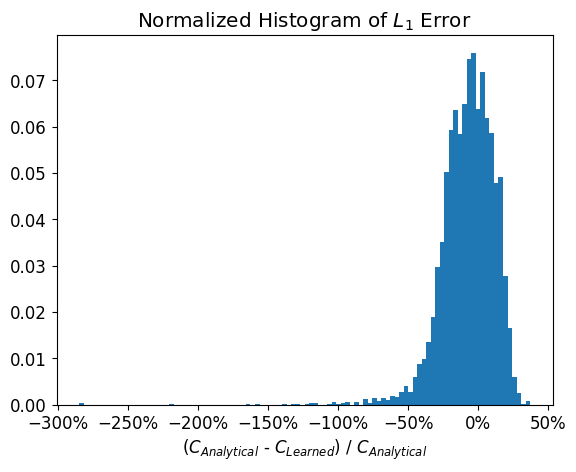

In [32]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

In [33]:
data = df[(df.norm_delta > 0.2) | (df.norm_delta < -0.2)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
638,0.855,0.018,0.003,0.124,64.0,7.945954e-08,2048,9.403325,712662181,7.895,10,2,0.494284,0.128452,-0.365832,-2.848014
162,0.875,0.117,0.000,0.008,32.0,3.480440e-08,4096,17.017830,675777512,11.895,28,10,0.592644,0.154744,-0.437899,-2.829820
267,0.380,0.044,0.003,0.573,64.0,2.498667e-08,1024,17.847826,972394229,13.365,30,6,0.518074,0.161890,-0.356184,-2.200155
431,0.809,0.094,0.003,0.094,16.0,4.633356e-08,2048,11.913139,744254317,11.680,14,3,0.666584,0.251437,-0.415148,-1.651104
1278,0.404,0.016,0.002,0.578,64.0,2.160226e-09,1024,14.701929,406832692,12.920,14,2,0.494539,0.190953,-0.303586,-1.589851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,0.438,0.036,0.446,0.080,4.0,7.970868e-08,8192,11.318216,734931115,1.434,12,1,5.804728,8.725636,2.920908,0.334750
4438,0.028,0.032,0.931,0.009,4.0,9.641156e-08,8192,17.908807,340458249,16.007,11,1,7.150095,11.007274,3.857179,0.350421
4309,0.137,0.280,0.468,0.115,4.0,9.251416e-08,8192,17.930211,985746790,10.536,15,3,9.723281,15.012442,5.289161,0.352318
2854,0.025,0.004,0.660,0.311,4.0,9.020113e-08,8192,6.234526,798782250,1.221,18,7,15.885591,24.532766,8.647175,0.352475


In [34]:
cutoff = 1
df[(df['norm_delta'] > cutoff) | (df['norm_delta'] < -cutoff)]

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
162,0.875,0.117,0.000,0.008,32.0,3.480440e-08,4096,17.017830,675777512,11.895,28,10,0.592644,0.154744,-0.437899,-2.829820
267,0.380,0.044,0.003,0.573,64.0,2.498667e-08,1024,17.847826,972394229,13.365,30,6,0.518074,0.161890,-0.356184,-2.200155
340,0.615,0.111,0.177,0.097,8.0,6.648201e-09,8192,16.294631,967626159,8.917,6,1,2.516958,1.245829,-1.271130,-1.020309
431,0.809,0.094,0.003,0.094,16.0,4.633356e-08,2048,11.913139,744254317,11.680,14,3,0.666584,0.251437,-0.415148,-1.651104
463,0.812,0.153,0.002,0.033,32.0,2.172038e-08,2048,8.080195,841717062,7.904,17,9,0.979503,0.448598,-0.530905,-1.183475
638,0.855,0.018,0.003,0.124,64.0,7.945954e-08,2048,9.403325,712662181,7.895,10,2,0.494284,0.128452,-0.365832,-2.848014
687,0.101,0.135,0.006,0.758,128.0,5.126056e-08,1024,19.369040,703175228,15.139,3,1,0.549251,0.255767,-0.293484,-1.147465
852,0.112,0.398,0.350,0.140,4.0,1.886693e-09,8192,19.445020,809017630,10.676,5,1,6.450022,2.764990,-3.685032,-1.332747
1212,0.812,0.032,0.023,0.133,64.0,9.036167e-08,2048,14.611526,187057876,11.158,2,1,0.672697,0.303742,-0.368956,-1.214701
1278,0.404,0.016,0.002,0.578,64.0,2.160226e-09,1024,14.701929,406832692,12.920,14,2,0.494539,0.190953,-0.303586,-1.589851


In [35]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

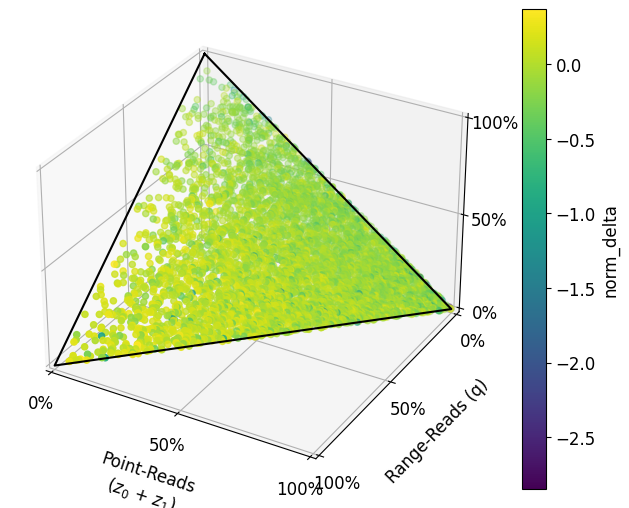

In [36]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

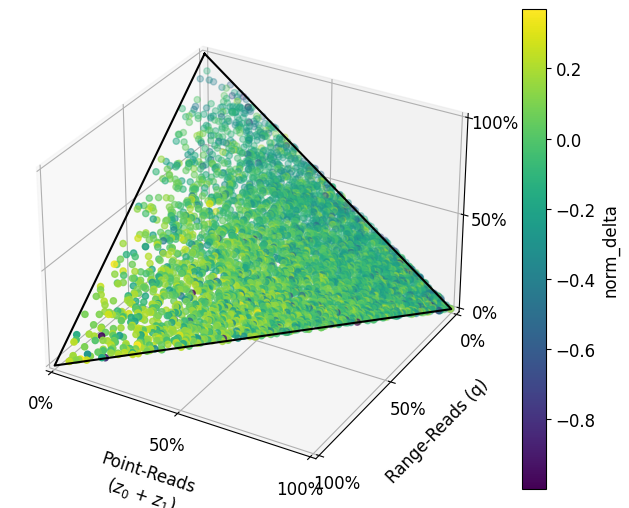

In [37]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 1) & (df.norm_delta > -1)], 'norm_delta')

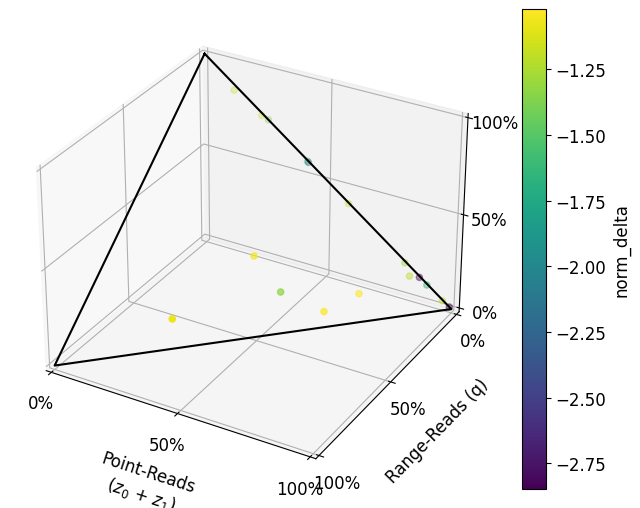

In [38]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 1) | (df.norm_delta < -1)], 'norm_delta')

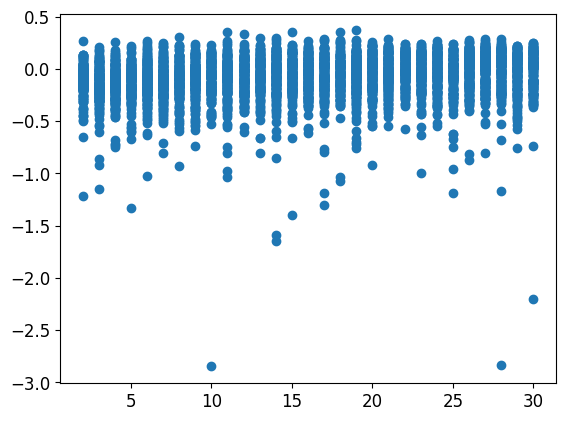

In [39]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['T'], df.norm_delta)
None

In [40]:
df.s

0       8.304847e-08
1       5.121860e-08
2       3.648064e-08
3       1.772925e-08
4       2.774510e-08
            ...     
4995    4.320507e-08
4996    8.622217e-08
4997    6.686893e-08
4998    8.218817e-08
4999    8.327988e-08
Name: s, Length: 5000, dtype: float64

In [ ]:
config['lsm']

In [ ]:
table = []
z0, z1, q, w = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
design.policy = Policy.Leveling

for size_ratio in range(config['lsm']['size_ratio']['min'], config['lsm']['size_ratio']['max']):
    for bpe in np.arange(config['lsm']['bits_per_elem']['min'], system.H, 0.1):
        design.T = size_ratio
        design.h = bpe
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            'T': design.T,
        }
        row["policy"] = design.policy.value
        row["cost_lcm"] = cost_lcm
        row["cost_acm"] = cost_acm
        table.append(row)
table = pd.DataFrame(table)

In [ ]:
from mpl_toolkits.mplot3d import proj3d

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "3d"})
Y = range(config['lsm']['size_ratio']['min'], config['lsm']['size_ratio']['max'])
X = np.arange(config['lsm']['bits_per_elem']['min'], system.H, 0.1)
X, Y = np.meshgrid(X, Y)
lcmZ = table.cost_lcm.values.reshape(X.shape)
acmZ = table.cost_acm.values.reshape(X.shape)

surfa = ax.plot_surface(Y, X, acmZ, color='tab:gray',# cmap=cm.Greys,
                       linewidth=0, antialiased=True,
                       alpha=0.5, label='Analytical')
surfa._facecolors2d = surfa._facecolor3d
surfa._edgecolors2d = surfa._edgecolor3d
surfb = ax.plot_surface(Y, X, lcmZ, color='tab:blue',# cmap=cm.Greens,
                       linewidth=0.1, antialiased=True,
                       alpha=0.5, label='Learned')
surfb._facecolors2d = surfb._facecolor3d
surfb._edgecolors2d = surfb._edgecolor3d

f = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]
ax.legend(['Analytical', 'Learned'], bbox_to_anchor=f(30, 6, 6), bbox_transform=ax.transData)
ax.set_xlabel('Size Ratio')
ax.set_ylabel('Filter Bits/Key')
ax.set_zlabel('I/O per Query')
ax.set_box_aspect(aspect=None, zoom=0.9)

In [ ]:
fig.savefig('surface_plot.pdf', dpi=400, bbox_inches='tight')